<a href="https://colab.research.google.com/github/Daviey52/try/blob/main/Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import numpy as np
import tensorflow as tf
import sys
import csv
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
np.random.seed(42)
tf.random.set_seed(42)


In [72]:
df = pd.read_csv('/content/MSFT.csv')
print(df)


            Date        Open        High         Low       Close   Adj Close  \
0      11/7/2016   59.779999   60.520000   59.779999   60.419998   55.902321   
1      11/8/2016   60.549999   60.779999   60.150002   60.470001   55.948589   
2      11/9/2016   60.000000   60.590000   59.200001   60.169998   55.671009   
3     11/10/2016   60.480000   60.490002   57.630001   58.700001   54.310928   
4     11/11/2016   58.230000   59.119999   58.009998   59.020000   54.607002   
...          ...         ...         ...         ...         ...         ...   
1254   11/1/2021  331.359985  331.489990  326.369995  329.369995  329.369995   
1255   11/2/2021  330.309998  333.450012  330.000000  333.130005  333.130005   
1256   11/3/2021  333.899994  334.899994  330.649994  334.000000  334.000000   
1257   11/4/2021  332.890015  336.540009  329.510010  336.440002  336.440002   
1258   11/5/2021  338.510010  338.790009  334.420013  336.059998  336.059998   

        Volume  
0     31664800  
1    

## Preprocessing

1.   Parse the Date Column and sort by Date
2.   Drop the Adj Close column
3.   Normalize numerica features(Open, High, Low, Close, Volume)




In [37]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by="Date", ascending=True, inplace=True)
print(df['Date'].is_monotonic_increasing)
df2 = df.drop(columns='Adj Close',)

exclude = ["Date"]
cols_to_scale = [c for c in df2.columns[1:] if c not in exclude]
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df2[cols_to_scale])

df_scaled = df2.copy()
df_scaled[cols_to_scale] = scaled_df
print (df_scaled.iloc[1:])



True
           Date      Open      High       Low     Close    Volume
1    2016-11-08  0.008277  0.006078  0.010356  0.008444  0.149396
2    2016-11-09  0.006315  0.005398  0.006928  0.007366  0.406553
3    2016-11-10  0.008028  0.005041  0.001263  0.002084  0.485441
4    2016-11-11  0.000000  0.000143  0.002634  0.003234  0.301900
5    2016-11-14  0.002819  0.000000  0.000000  0.000000  0.326565
...         ...       ...       ...       ...       ...       ...
1254 2021-11-01  0.974490  0.973901  0.970953  0.974598  0.189253
1255 2021-11-02  0.970744  0.980909  0.984051  0.988107  0.183608
1256 2021-11-03  0.983552  0.986093  0.986397  0.991233  0.135571
1257 2021-11-04  0.979949  0.991956  0.982283  1.000000  0.159576
1258 2021-11-05  1.000000  1.000000  1.000000  0.998635  0.145819

[1258 rows x 6 columns]


## Windowing


1.   Use a sliding window of N(20) days to predict next day's value
2.   Shape the input as (Sample, timesteps, features)



In [38]:
def sliding_window(df, features_cols,  window_size):
  X = []
  y = []

  features = df[features_cols].values

  for i in range (window_size, len(df)):
    X.append(features[i-window_size:i,:])
    y.append(features[i,:])
  return np.array(X), np.array(y)



In [39]:
window_size = 20
features_cols = ["Open", "High", "Low", "Close", "Volume"]


X, y = sliding_window(df_scaled, features_cols, window_size)

In [40]:
X.shape

(1239, 20, 5)

In [41]:
y.shape

(1239, 5)

In [42]:
train_idx = int(len(X) * 0.8)
val_idx   = int(len(X) * 0.9)

X_train = X[:train_idx]
y_train = y[:train_idx]

X_val = X[train_idx:val_idx]
y_val = y[train_idx:val_idx]

X_test = X[val_idx:]
y_test = y[val_idx:]

print(len(X_train), len(X_val), len(X_test))



991 124 124


## Modeling
### Build and train 3 different RNN models:


1.   Simple RNN
2.   GRU
3.   LSTM

All models should output 5 values(Open, High, Low , Close, Volume)



In [43]:
from tensorflow import keras

In [44]:
np.random.seed(42)
tf.random.set_seed(42)
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 5]),
    keras.layers.SimpleRNN(20,),
    keras.layers.Dense(5)
])
model.compile(loss="mse", optimizer=keras.optimizers.Adam(0.001))
model.summary()
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_val, y_val),callbacks=[early_stopping]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, None, 20)       │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,445 (5.64 KB)

 Trainable params: 1,445 (5.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0898 - val_loss: 0.0829
Epoch 2/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0137 - val_loss: 0.0298
Epoch 3/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0064 - val_loss: 0.0189
Epoch 4/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0044 - val_loss: 0.0137
Epoch 5/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0035 - val_loss: 0.0112
Epoch 6/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - val_loss: 0.0096
Epoch 7/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028 - val_loss: 0.0084
Epoch 8/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0026 - val_loss: 0.0073
Epoch 9/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0024 - val_loss: 0.0065
Epoch 10/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0023 - val_loss: 0.0058
Epoch 11/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0022 - val_loss: 0.0053
Epoch 12/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0

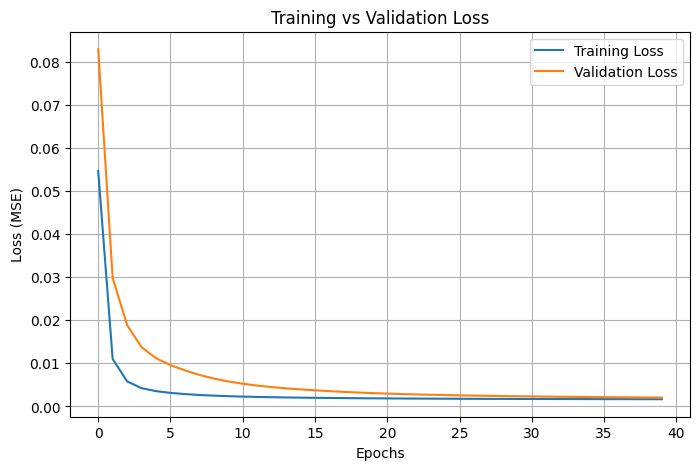

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [46]:
np.random.seed(42)
tf.random.set_seed(42)
model2 = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 5]),
    keras.layers.GRU(20),
    keras.layers.Dense(5)
])
model2.compile(loss="mse", optimizer=keras.optimizers.Adam(0.001))
model2.summary()
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
history2 = model2.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_val, y_val),callbacks=[early_stopping]
)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, None, 20)       │         1,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 20)             │         2,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,245 (16.58 KB)

 Trainable params: 4,245 (16.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.0360 - val_loss: 0.0213
Epoch 2/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0052 - val_loss: 0.0046
Epoch 3/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 4/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 5/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 6/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 7/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 8/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 9/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 10/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 11/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 12/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0

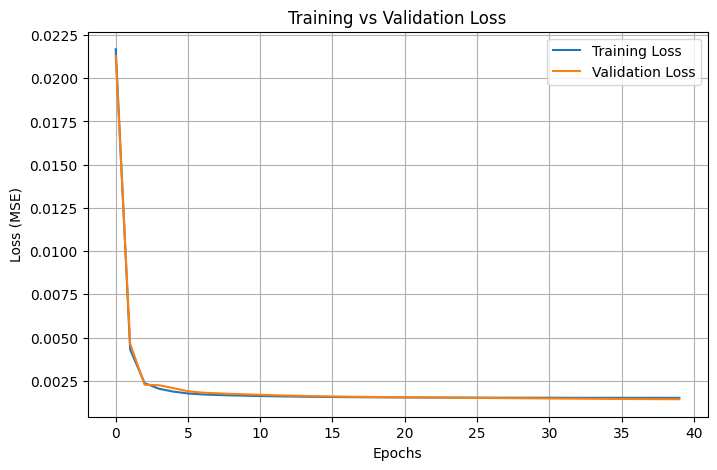

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history2.history["loss"], label="Training Loss")
plt.plot(history2.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [48]:
np.random.seed(42)
tf.random.set_seed(42)
model3 = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 5]),
    keras.layers.LSTM(20 ),
    keras.layers.Dense(5)
])
model3.compile(loss="mse", optimizer=keras.optimizers.Adam(0.001))
model3.summary()
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
history3 = model3.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_val, y_val),callbacks=[early_stopping]
)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, None, 20)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 20)             │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │           105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,465 (21.35 KB)

 Trainable params: 5,465 (21.35 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0237 - val_loss: 0.0244
Epoch 2/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0035 - val_loss: 0.0047
Epoch 3/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0023 - val_loss: 0.0042
Epoch 4/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0021 - val_loss: 0.0034
Epoch 5/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0021 - val_loss: 0.0031
Epoch 6/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 7/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 8/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0020 - val_loss: 0.0027
Epoch 9/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 10/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 11/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 12/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0

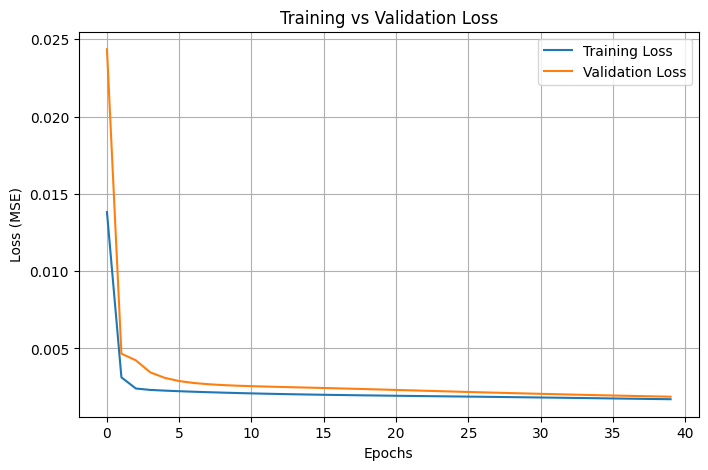

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history3.history["loss"], label="Training Loss")
plt.plot(history3.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

## Evaluation


1.   Predict all the 5 column for the 10 business days between 11/08/2021 and 11/19/2021
2.   Evaluate the prediction using MSE or MAE for each feature
3.   Plot predicted vs true value for each column



### Simple RNN

#### 10 days predictions


In [50]:
def predict_future_days(model, df_scaled, features_cols, window_size, n_days):
  window = df_scaled[features_cols].values[-window_size:]

  predictions = []

  for i in range(n_days):
    X_input = window.reshape(1,window_size, len(features_cols))

    pred = model.predict(X_input)
    predictions.append(pred[0])

    window = np.vstack([window[1:],pred[0]])

  return np.array(predictions)

In [52]:
columns = ["Open", "High", "Low", "Close", "Volume"]
future_scaled_Srnn = predict_future_days(model,df_scaled,columns,window_size=20,n_days=10)
future_Srnn = scaler.inverse_transform(future_scaled_Srnn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [55]:
simpleRNN_predTable =pd.DataFrame(future_Srnn, columns=columns)
print(simpleRNN_predTable)

         Open        High         Low       Close      Volume
0  285.691681  298.179596  279.069427  309.159454  36689636.0
1  284.712006  304.065857  281.416779  282.363739  40756688.0
2  284.665802  286.260315  264.821075  272.682465  50933244.0
3  263.005707  292.719574  273.079620  234.880310  61191912.0
4  248.599838  267.772552  255.019089  248.156128  67464408.0
5  253.853622  267.854706  250.527618  234.060364  67295336.0
6  245.119492  250.540939  234.087128  256.914825  60888228.0
7  241.297394  266.881439  243.021469  226.442657  64704984.0
8  247.939224  242.846313  225.172729  257.255005  71131840.0
9  235.695557  261.296844  241.091400  208.494949  73357752.0


### Simple RNN MSE calulation

In [62]:
import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true_values = scaler.inverse_transform(y_test)
mae = {}
for i, col in enumerate (["Open","High","Low","Close","Volume"]):
  mae[col] = mean_absolute_error(y_true_values[:, i], y_pred[:, i])
print("MAE per feature:")
for k, v in mae.items():
    print(f"{k}: {v:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
{'Open': 22.5540812898658, 'High': 17.955827032691204, 'Low': 23.35330941433027, 'Close': 12.929352915936878, 'Volume': 10348463.241935484}
MAE per feature:
Open: 22.5541
High: 17.9558
Low: 23.3533
Close: 12.9294
Volume: 10348463.2419


### Simple RNN Plot predicted VS True

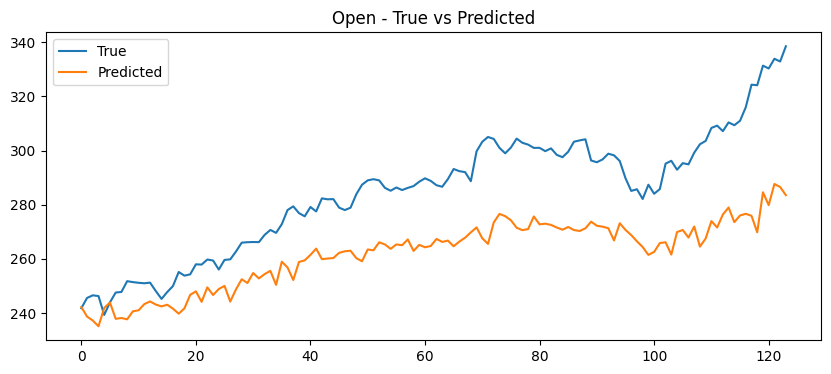

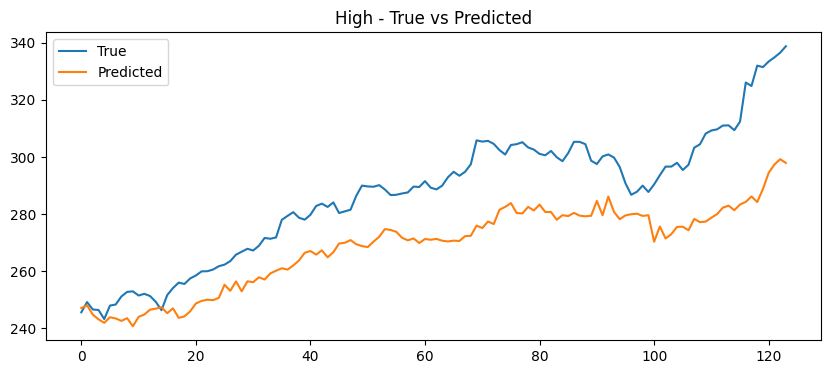

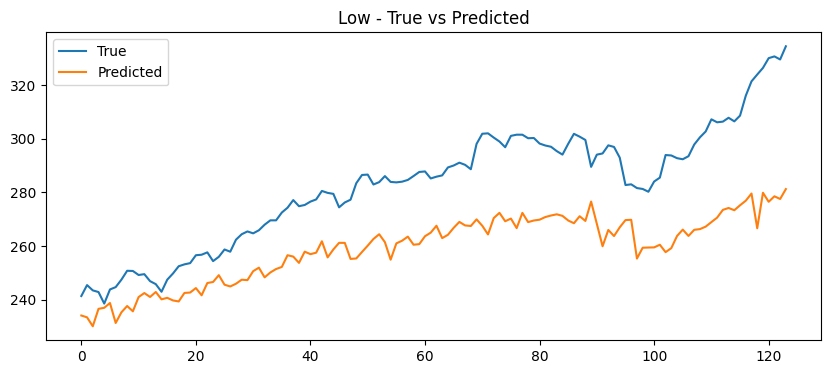

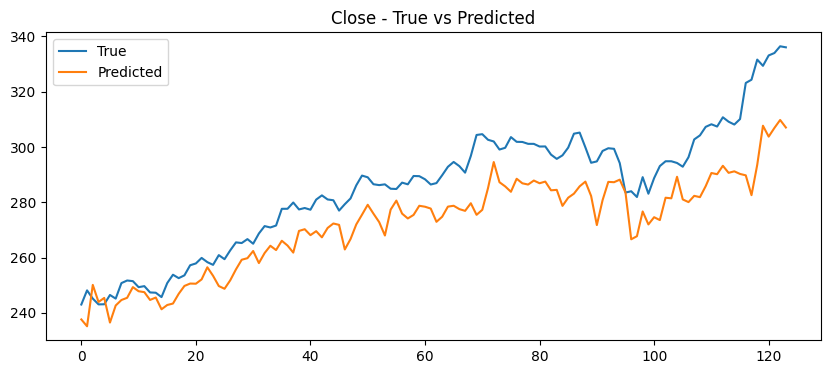

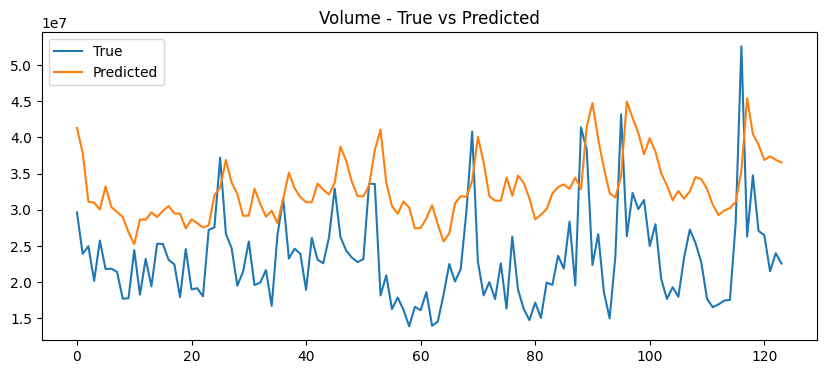

In [61]:
import matplotlib.pyplot as plt

for i, col in enumerate(["Open","High","Low","Close","Volume"]):
    plt.figure(figsize=(10,4))
    plt.plot(y_true_values[:, i], label="True")
    plt.plot(y_pred[:, i], label="Predicted")
    plt.title(f"{col} - True vs Predicted")
    plt.legend()
    plt.show()


### GRU
#### 10 days predictions

In [63]:
future_scaled_GRU = predict_future_days(model2, df_scaled, columns, window_size=20, n_days=10)
future_GRU_pred = scaler.inverse_transform(future_scaled_GRU)
GRU_predTable = pd.DataFrame(future_GRU_pred, columns=columns)
print(GRU_predTable)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
         Open        High         Low       Close      Volume
0  308.260803  308.197601  303.550964  308.940460  25022160.0
1  298.788422  300.735016  297.133270  296.960938  28224226.0
2  289.669220  293.775238  288.369476  286.658691  30228882.0
3  281.633698  286.904144  280.894257  279.260834  32004422.0
4  274.910187  280.365936  274.141815  273.028229  33376876.0
5  269.119202  274.516510  268.162140  267.641266  34506620.0
6  264.036530  269.298706  262.874390  262.871216  35434468.0
7  259.549835  264.655365  258.194153  258.646851  36222840.0
8  255.560364  260.504150  254.005203  254.871017  36895232.0

MSE Calulations

In [64]:
y_pred_scaled = model2.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true_values = scaler.inverse_transform(y_test)
mae = {}
for i, col in enumerate (["Open","High","Low","Close","Volume"]):
  mae[col] = mean_absolute_error(y_true_values[:, i], y_pred[:, i])
print("MAE per feature:")
for k, v in mae.items():
    print(f"{k}: {v:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step 
MAE per feature:
Open: 13.8555
High: 14.1665
Low: 14.0924
Close: 12.8761
Volume: 5477244.3226


GRU plot predicted VS True

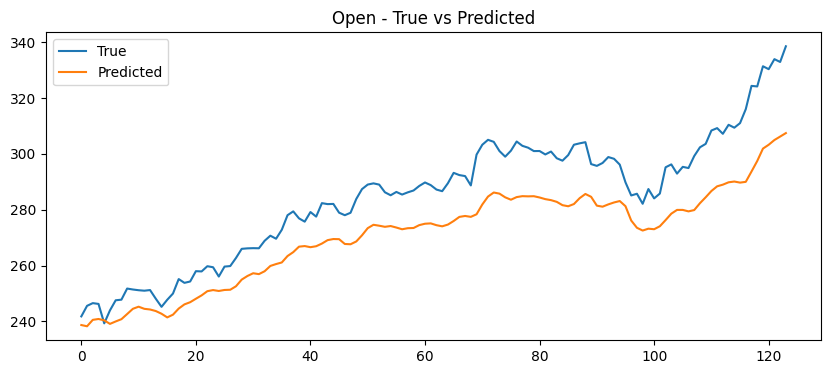

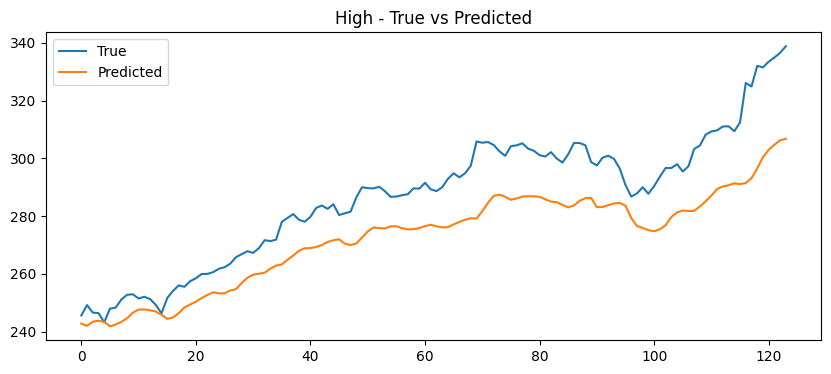

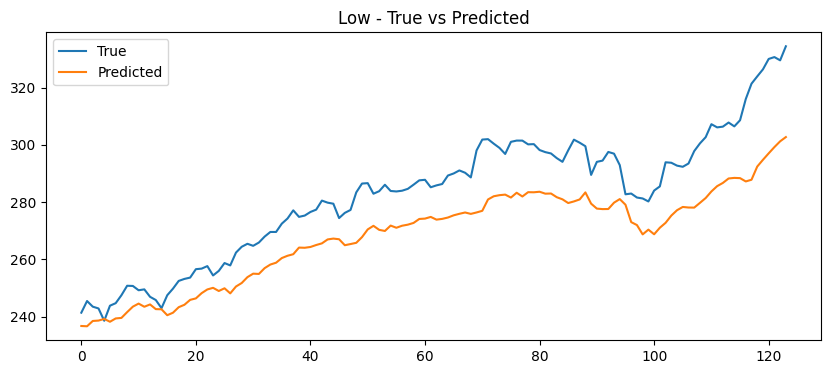

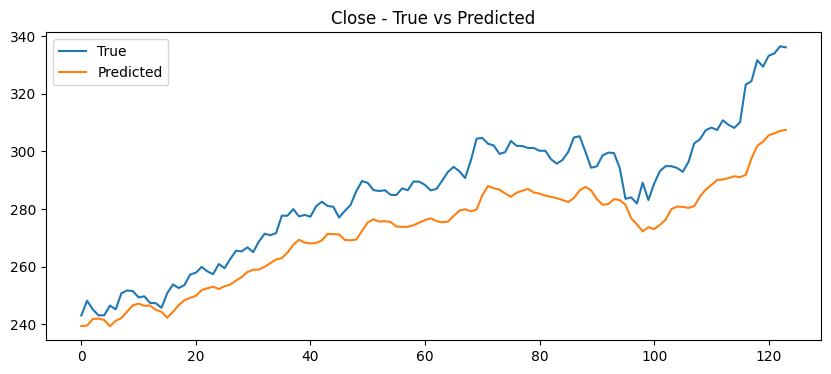

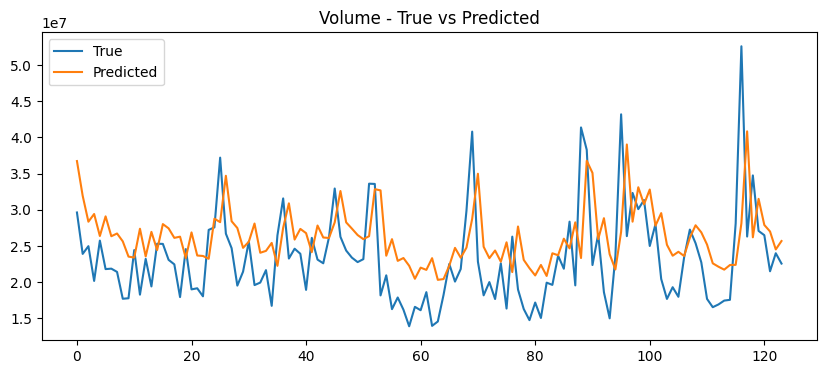

In [65]:
for i, col in enumerate(["Open","High","Low","Close","Volume"]):
    plt.figure(figsize=(10,4))
    plt.plot(y_true_values[:, i], label="True")
    plt.plot(y_pred[:, i], label="Predicted")
    plt.title(f"{col} - True vs Predicted")
    plt.legend()
    plt.show()



### LSTM


### 10 days prediction

In [69]:
future_scaled_LSTM = predict_future_days(model3, df_scaled,columns, window_size=20, n_days=10)
future_LSTM_pred = scaler.inverse_transform(future_scaled_LSTM)
LSTM_predTable = pd.DataFrame(future_LSTM_pred, columns=columns)
print(LSTM_predTable)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
         Open        High         Low       Close      Volume
0  288.222137  292.791443  286.499390  278.291931  23167148.0
1  286.360352  290.649902  285.986084  275.731415  27920038.0
2  283.785004  288.269531  283.168091  272.774902  30396058.0
3  281.274750  285.715881  279.904572  270.618408  31657128.0
4  278.912933  283.109161  276.692383  269.006226  32283592.0
5  276.703888  280.553741  273.690308  267.680756  32633758.0
6  274.609344  278.090881  270.914795  266.447632  32892728.0
7  272.585236  275.746429  268.355865  265.201874  33149828.0
8  270.614746  273.518066  265.976990  263.908783  33433392.0


### MSE Calulations

In [70]:
y_pred_scaled = model3.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true_values = scaler.inverse_transform(y_test)
mae = {}
for i, col in enumerate (["Open","High","Low","Close","Volume"]):
  mae[col] = mean_absolute_error(y_true_values[:, i], y_pred[:, i])
print("MAE per feature:")
for k, v in mae.items():
    print(f"{k}: {v:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
MAE per feature:
Open: 18.4875
High: 17.1635
Low: 19.7952
Close: 25.3724
Volume: 4780007.3871


### LSTM plot: Predicted VS True

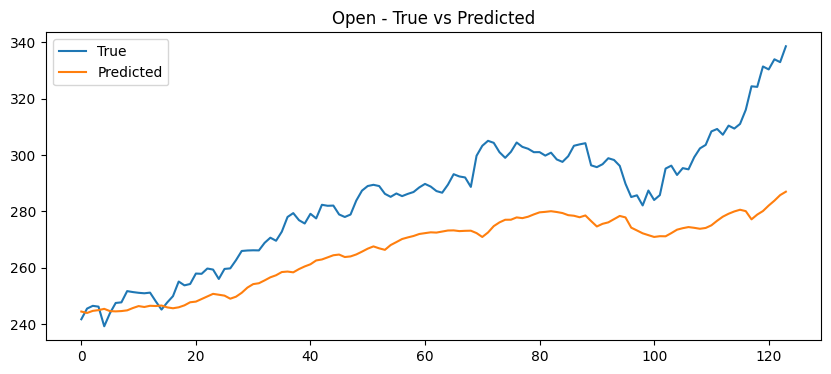

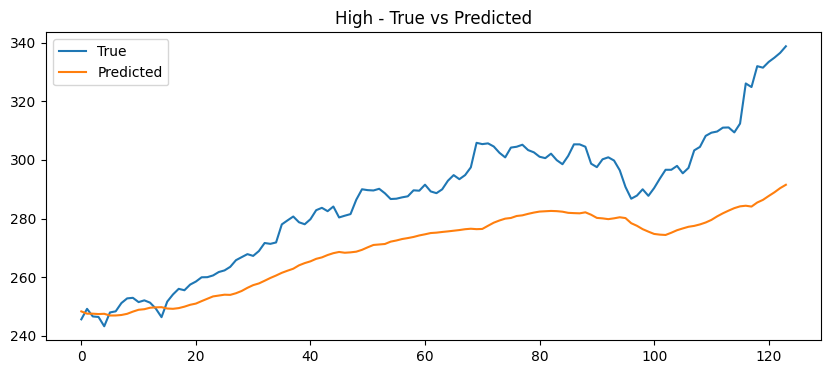

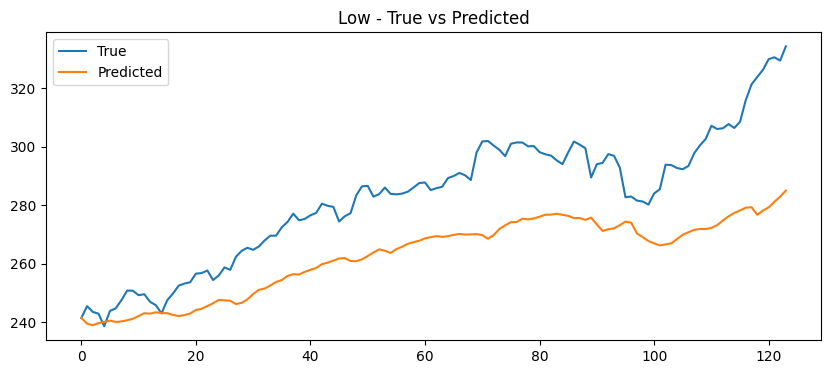

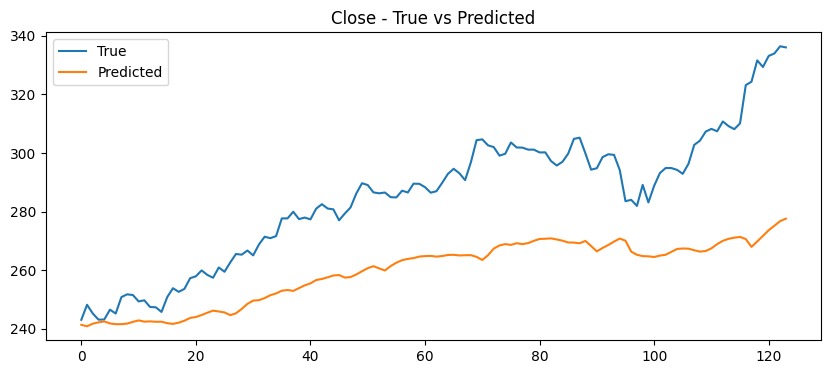

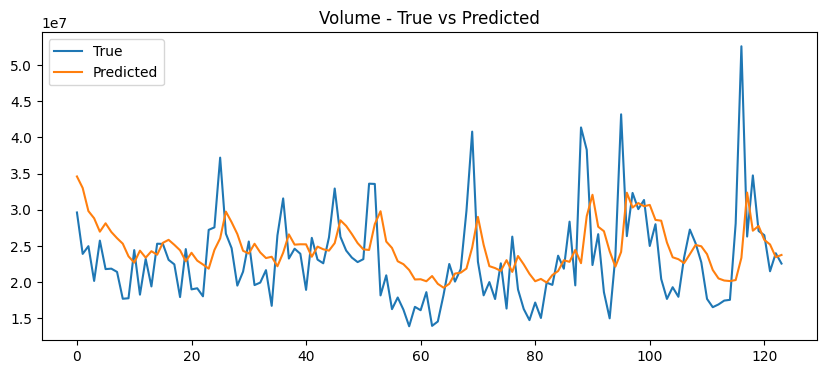

In [71]:
for i, col in enumerate(["Open","High","Low","Close","Volume"]):
    plt.figure(figsize=(10,4))
    plt.plot(y_true_values[:, i], label="True")
    plt.plot(y_pred[:, i], label="Predicted")
    plt.title(f"{col} - True vs Predicted")
    plt.legend()
    plt.show()



### Evaluation of the models

#### Evaluation of performance was based on MAE scores. GRU had the lowest MAE values for 4(Open, High, Low, Close, Volume) of the 5 features. LSTM performed second best showing competive accuracy and achieving lowest MAE for volume. SimpleRNN has the highest MAE values across all the 5 features, meaning it had the highest errors in prediction.

In [76]:
import os
os.listdir('/content')



['.config', 'MSFT.csv', 'sample_data']